In [1]:
from PyUoI.UoI_Lasso import UoI_Lasso
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('text', usetex = True)
rc('font',**{'family' : 'serif', 'serif' : ['Computer Modern Roman']})
plt.style.use('ggplot')
import numpy as np

In [2]:
def fit_metrics(estimate, true):
    false_positive = np.count_nonzero(estimate[true == 0])
    false_negative = np.count_nonzero(true[estimate == 0])
    bias = estimate - true
    
    # plot
    fig, ax = plt.subplots()
    ax.scatter(true, estimate)
    ax.plot(ax.get_xlim(), ax.get_xlim(), linewidth = 3)
    ax.set_xlabel('True', fontsize = 25)
    ax.set_ylabel('Estimates', fontsize = 25)
    return false_positive, false_negative, bias

In [3]:
def basic_test(n_features=10, n_samples=50, noise_scale=0.5, sparsity=1., groups=np.ones(10)):
    # calculate number of nonzero parameters
    num_nonzero = int(sparsity * n_features)
    # create design matrix
    X = np.random.normal(size=(n_samples, n_features))
    # choose model parameters
    beta = np.zeros(shape=(n_features, 1))
    nonzero_idx = np.random.choice(np.arange(n_features), num_nonzero, replace=True)
    beta[nonzero_idx, 0] = np.random.laplace(size=(num_nonzero))
    # choose noise
    noise = np.random.normal(scale=noise_scale, size=(n_samples, 1))
    # generate output
    y = np.dot(X, beta) + noise
    # run UoI Lasso
    uoi = UoI_Lasso()
    uoi.fit(X, y, groups=groups)
    # compute metrics
    fp, fn, bias = fit_metrics(uoi.coef_, beta.ravel())
    print('False Positives: ', fp)
    print('False Negatives: ', fn)
    plt.show()
    return

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


False Positives:  0
False Negatives:  1


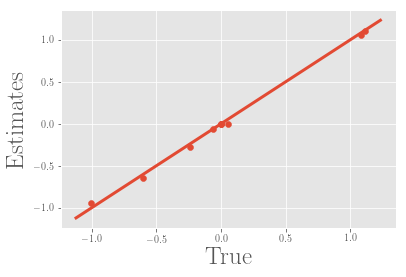

In [4]:
basic_test(n_features=10, n_samples=400, 
           groups=np.concatenate((np.ones(200), 2*np.ones(200))))

In [5]:
n_samples=10
n_features=100
num_nonzero=10
noise_scale=.5

X = np.random.normal(size=(n_samples, n_features))
# choose model parameters
beta = np.zeros(shape=(n_features, 1))
nonzero_idx = np.random.choice(np.arange(n_features), num_nonzero, replace=True)
beta[nonzero_idx, 0] = np.random.laplace(size=(num_nonzero))
# choose noise
noise = np.random.normal(scale=noise_scale, size=(n_samples, 1))
# generate output
y = np.dot(X, beta) + noise
# run UoI Lasso
uoi = UoI_Lasso()
uoi.fit(X, y,groups=np.array([1,1,2,2,3,3,3,4,4,4]))

No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambd

No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambd

No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambda = 0.
No variables selected in the support for lambd

UoI_Lasso(bagging_options=1, copy_X=True, estimation_score='BIC',
     fit_intercept=True, n_boots_coarse=10, n_boots_est=48, n_boots_sel=48,
     n_lambdas=48, n_selection_thres=1, normalize=False,
     selection_thres_max=1.0, selection_thres_min=1.0, train_frac_est=0.8,
     train_frac_overall=0.9, train_frac_sel=0.8, use_admm=False)

In [5]:
uoi.groups_

[1, 1, 2, 2, 3, 3, 3, 4, 4, 4]

In [7]:
np.array(np.array([1,2,3,4]))

array([1, 2, 3, 4])